In [1]:
# Fitting formula functions
def dyn_ej(a = -9.3335, b = 114.17, d = -337.56, n = 1.5465, M1 = 1.4, R1 = 10, M2 = 1.4, R2 = 10):
    C1 = 1.476625 * M1 / R1
    C2 = 1.476625 * M2 / R2
    x = (a/C1 + b*(M2**n/M1**n) + d*C1)*M1 + (a/C2 + b*(M1**n/M2**n) + d*C2)*M2
    if x < 0:
        return 0
    else:
        return x/1000
    
def wind_ej(M1, M2, a0=-1.581, deltaa=-2.439, b0=-0.538, deltab=-0.406, c=0.953, d=0.0417, beta=3.91, qtrans=0.9, Mtov=1.97, R16=11.137): 
    Mtresh = (2.38 - 3.606 * (Mtov/R16))*Mtov
    q = M2/M1
    xsi = 0.5 * np.tanh(beta * (q - qtrans))
    a = a0 + deltaa * xsi
    b = b0 + deltab * xsi
    mwind = a * (1 + b * np.tanh( (c - (M1+M2)/Mtresh)/d ))
    if -3 > mwind:
        return -3
    else:
        return mwind
    

# mass chirp
def chirp_mass(m1, m2):
    return (m1*m2)**(3/5) / (m1 + m2)**(1/5)

# mass ratio
def mass_ratio(m1, m2):
    return m2 / m1

In [20]:
import pandas as pd
import numpy as np

#samples = pd.read_csv('/home/liteul/memoir_code/170817large_prior_GWresample/posterior_samples.dat', delim_whitespace=True)
#EM_samples = pd.read_csv('/home/liteul/memoir_code/170817_large_priors/4096large_prior_posterior_samples.dat', delim_whitespace=True)
samples = pd.read_csv('/home/liteul/memoir_code/170817_dist_prior_GWresample/posterior_samples.dat', delim_whitespace=True)
EM_samples = pd.read_csv('/home/liteul/memoir_code/170817_dist_priors/4096dist_prior_posterior_samples.dat', delim_whitespace=True)
#samples = pd.read_csv('/home/liteul/memoir_code/170817_incl_prior_GWresample/posterior_samples.dat', delim_whitespace=True)
#EM_samples = pd.read_csv('/home/liteul/memoir_code/170817_incl_priors/4096incl_prior_posterior_samples.dat', delim_whitespace=True)
#samples =pd.read_csv('/home/liteul/memoir_code/170817_incl2_prior_GWresample/posterior_samples.dat', delim_whitespace=True)
#EM_samples = pd.read_csv('/home/liteul/memoir_code/170817_incl_priors/4096incl_prior_tf_posterior_samples.dat', delim_whitespace=True)


In [21]:
import numpy as np

Mc = samples["chirp_mass"]
q  = samples["mass_ratio"]

m1 = Mc * (1 + q)**(1/5) * q**(-3/5)
m2 = m1 * q

samples["m1"] = m1
samples["m2"] = m2


In [22]:
# recup ejecta EM data
log10_mej_dyn = EM_samples["log10_mej_dyn"]
log10_mej_wind = EM_samples["log10_mej_wind"]


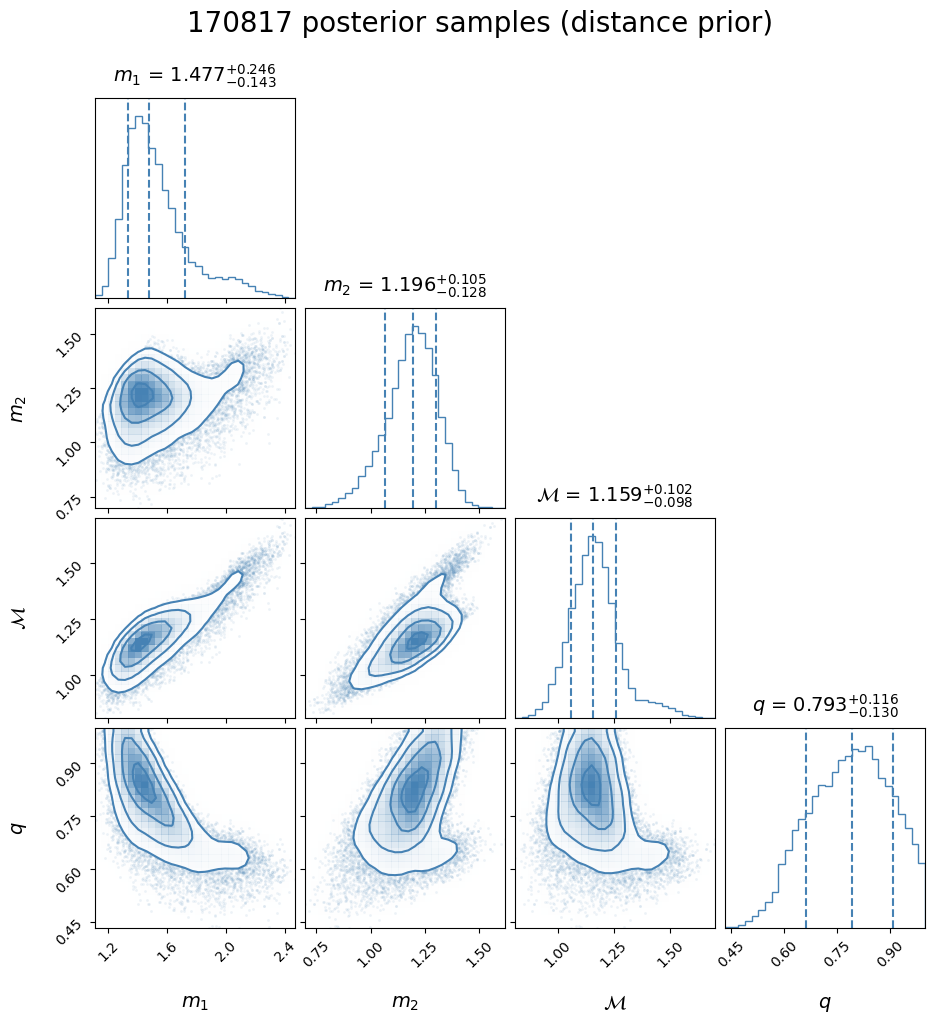

In [ ]:
import corner 
import matplotlib.pyplot as plt

figure = corner.corner(
    samples[["m1", "m2", "chirp_mass", "mass_ratio"]],
    labels=["$m_1$", "$m_2$", "$\mathcal{M}$", "$q$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt='.3f',
    title_kwargs={
        'fontsize': 14,
        'pad': 12},
    label_kwargs={
        'fontsize': 14},
    smooth=1.0,
    bins=30,
    color='steelblue',
    hist_kwargs={'density': True},
    max_n_ticks=4,
    figsize=(12, 12),
    labelpad=0.03,  
    )
# set the figure suptitle and then show the plot
figure.suptitle("170817 posterior samples (distance prior)", y=1.05, fontsize=20)
#figure.savefig("170817_dist_prior_GWresample/dist_prior_qchirp_to_masses.png", bbox_inches='tight')
plt.show()

Best fit EOS: 4693
R16 = 10.959132352941177 km
M_tov = 2.11914 Msun


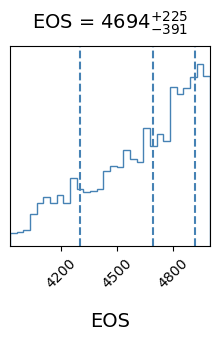

In [25]:
# Extract best fit EOS to compute ejecta masses
samples['EOS']
# plot EOS distribution
figure = corner.corner(
    samples[["EOS"]],
    labels=["EOS"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt='.0f',
    title_kwargs={
        'fontsize': 14,
        'pad': 12},
    label_kwargs={
        'fontsize': 14},
    smooth=1.0,
    bins=30,
    color='steelblue',
    hist_kwargs={'density': True},
    max_n_ticks=4,
    figsize=(6, 6),
    labelpad=0.03,  
    )
# Get the best fit EOS
best_EOS = int(samples['EOS'].median())
print("Best fit EOS:", best_EOS)

# import EOS properties
EOS_properties = np.loadtxt(f'/home/liteul/memoir_code/NMMA/EOS/15nsat_cse_uniform_R14/macro/{best_EOS}.dat')
# 1ere col: radius km
# 2eme col: mass in solar mass units
# build mass-radius relation
R_EOS = EOS_properties[:,0]
Mass_EOS = EOS_properties[:,1]
# Interpolate to get 1.6 msun radius
R16 = np.interp(1.6, Mass_EOS, R_EOS)
print("R16 =", R16, "km")
# Get max mass
M_tov = np.max(Mass_EOS)
print("M_tov =", M_tov, "Msun")

/tmp/ipykernel_9063/2422364971.py:19: RuntimeWarning: divide by zero encountered in log10
  safe_log_dyn = np.where(dyn_ejecta_arr > 0, np.log10(dyn_ejecta_arr), np.nan)


EM samples shape: (20274, 2)


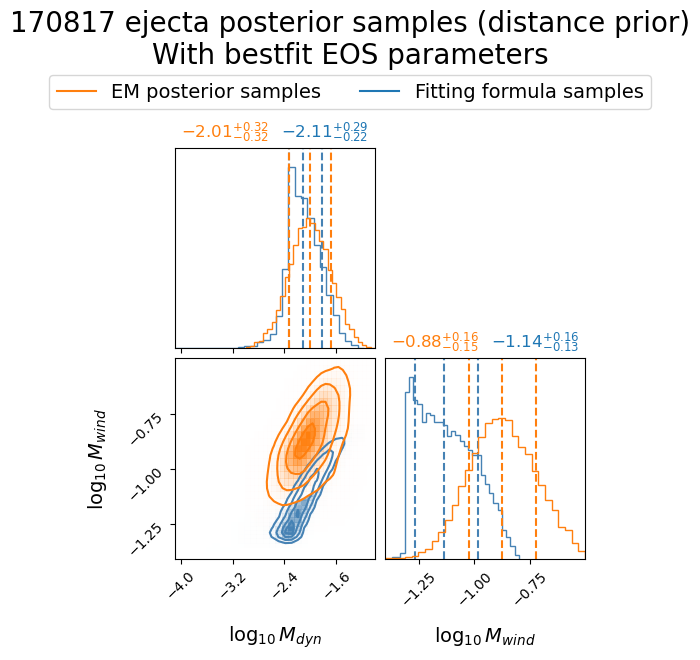

In [27]:
# Convert M1 M2 to dynamical and wind ejecta masses
dyn_ejecta = []
wind_ejecta = []
for i in range(len(samples)):
    m1 = samples["m1"].iloc[i]
    m2 = samples["m2"].iloc[i]
    # get radius from EOS for the 2 NS
    R1 = np.interp(m1, Mass_EOS, R_EOS)
    R2 = np.interp(m2, Mass_EOS, R_EOS)
    dyn_ej_i = dyn_ej(M1=m1, M2=m2, R1=R1, R2=R2)
    wind_ej_i = wind_ej(M1=m1, M2=m2)
    dyn_ejecta.append(dyn_ej_i)
    wind_ejecta.append(wind_ej_i+np.log10(0.3))

# ATTENTION: wind_ejecta is already in log10 scale from fitting formula and we assume a certain EOS

# safe log10: avoid -inf from log10(0) by setting non-positive entries to NaN
dyn_ejecta_arr = np.array(dyn_ejecta, dtype=float)
safe_log_dyn = np.where(dyn_ejecta_arr > 0, np.log10(dyn_ejecta_arr), np.nan)

samples["log_dyn_ejecta"] = safe_log_dyn
samples["log_wind_ejecta"] = wind_ejecta

# drop rows with NaN before plotting (corner cannot plot NaN/Inf)
plot_samples = samples[["log_dyn_ejecta", "log_wind_ejecta"]].dropna()
if plot_samples.shape[0] == 0:
    raise RuntimeError("No valid ejecta points to plot (all dyn ejecta <= 0).")

# plot corner plot of dynamical and wind ejecta masses
figure = corner.corner(
    plot_samples,
    labels=["$\log_{10} M_{dyn}$", "$\log_{10} M_{wind}$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=0,
    title_fmt='.3f',
    title_kwargs={
        'fontsize': 10,
        'pad': 12},
    label_kwargs={
        'fontsize': 14},
    smooth=1.0,
    bins=30,
    color='steelblue',
    hist_kwargs={'density': True},
    max_n_ticks=4,
    figsize=(8, 8),
    labelpad=0.03,  
    plot_datapoints=False,
    fill=False
    )

df_em = pd.concat([log10_mej_dyn, log10_mej_wind], axis=1, join='inner')
df_em.columns = ['log10_mej_dyn', 'log10_mej_wind']
df_em = df_em.dropna()
print("EM samples shape:", df_em.shape)

# pass a DataFrame (or .values) to corner — not a plain list
corner.corner(
    df_em,                        # or df_em.values
    labels=[r"$\log_{10} M_{dyn}$", r"$\log_{10} M_{wind}$"],
    quantiles=[0.16, 0.5, 0.84],
    fig=figure,
    plot_datapoints=False,
    show_titles=0,
    title_fmt='.3f',
    title_kwargs={
        'fontsize': 10,
        'pad': 12,
        'color': 'tab:orange'},
    label_kwargs={
        'fontsize': 14},
    smooth=1.0,
    bins=30,
    color='tab:orange',
    hist_kwargs={'density': True},
    max_n_ticks=4,
    figsize=(8, 8),
    labelpad=0.03,  
    fill=False
)

handles = [
    plt.Line2D([], [], color="tab:orange", label="EM posterior samples"),
    plt.Line2D([], [], color="tab:blue", label="Fitting formula samples"),
]
figure.legend(handles=handles, ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.03), loc='center')

# --- Ajout des quantiles au-dessus des distributions 1D ---
quantiles = [0.16, 0.5, 0.84]

axes = np.array(figure.axes).reshape(2, 2)

for i in range(len(plot_samples.columns)):
    ax = axes[i, i]

    # jeu de données bleu
    q1 = np.percentile(plot_samples.iloc[:, i], [16, 50, 84])
    text1 = rf"${q1[1]:.2f}^{{+{(q1[2]-q1[1]):.2f}}}_{{-{(q1[1]-q1[0]):.2f}}}$"
    ax.text(0.75, 1.02, text1, color="C0", ha="center", va="bottom", transform=ax.transAxes, size=12)

    # jeu de données orange
    q2 = np.percentile(df_em.iloc[:, i], [16, 50, 84])
    text2 = rf"${q2[1]:.2f}^{{+{(q2[2]-q2[1]):.2f}}}_{{-{(q2[1]-q2[0]):.2f}}}$"
    ax.text(0.25, 1.02, text2, color="C1", ha="center", va="bottom", transform=ax.transAxes, size=12)

figure.suptitle("170817 ejecta posterior samples (distance prior)\nWith bestfit EOS parameters", y=1.18, fontsize=20)
#figure.savefig("170817_dist_prior_GWresample/dist_prior_ejecta_corner_plot_eos.png", bbox_inches='tight')
plt.show()


In [ ]:
# Plot disk wind ejecta with fixed 30% of disk mass distribution
